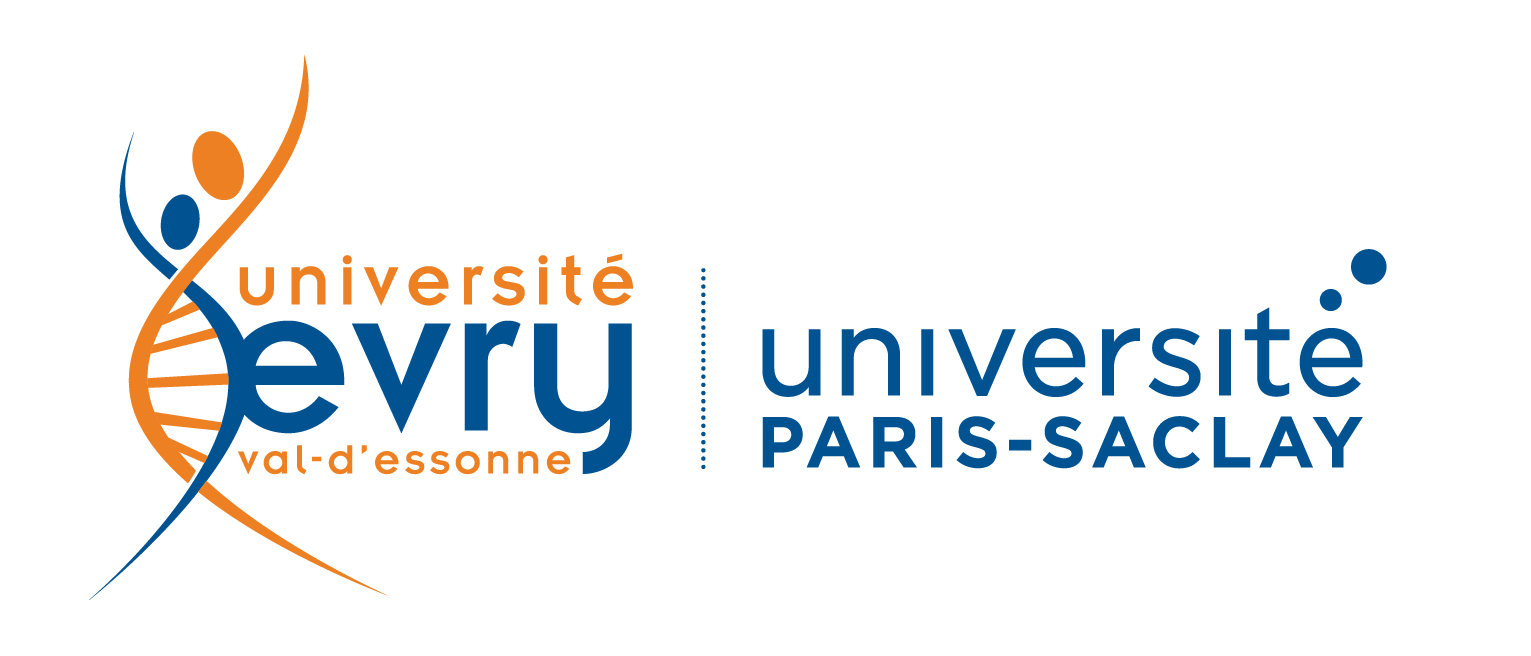

## BOUFALA Yacine 
    -20184427@etud.univ-evry.fr
## KHALFOUN Rayan 
    -20183621@etud.univ-evry.fr

---

In [1]:
import os
import re
import heapq
import struct 
import pickle
import numpy as np

In [2]:
class __FileReader__:
    
    def __init__(self, path='Data/', output_path='Compressed/'):
        self.path = path
        self.output_path = output_path

        
    def read_txt(self, filename, splitter=False):
        """
        lire et renvoyer le contenu du fichier
        Decoupant le texte par rapport au espace (en mots)
        """
        data = open(self.path + filename, 'r', encoding='utf-8').read()
        if splitter:
            return data.split(' ')
        return data


    def read_dir(self, index=0):
        """
        recupere tout les fichier d'un dossier
        """
        return os.listdir(self.path.format(index))
    

---

In [3]:
class ArithmeticCoding:
    
    def __init__(self):
        self.__EOF__ = '<|*EOF*|>' # mot de fin de chaine
        self.precision = 16 # par defaut dans le papier
        

    def getfreqs(self, stream):
        """
        Cette fonction prend un flux en entrée. il obtient le nombre d'occurrences de chaque symbole
        dans ce flux, stockez-le dans un dictionnaire contenant tous les symboles du flux.
        """
        symbols = set(stream) # supprimer les doublons dans le texte
        L = len(stream)
        
        Dict = {} # stocker chaque symbole avec sa probabilité correspondante
        
        # calculer la probabilité de chaque symbole dans le flux
        for s in symbols:
            freq = stream.count(s)
            Dict[s] = freq
            
        return Dict


    def Cumfreq(self, symbol, dictionary):
        """
        Cette fonction prend en entrée un symbole et un dictionnaire contenant tous les symboles 
        qui existent dans notre flux et leurs fréquenceset renvoie la fréquence cumulée à partir du 
        tout début du Dictionnaire jusqu'à ce Symbole.
        """
        P = 0
        for sym in dictionary:
            P = P + dictionary[sym]
            if sym == symbol:
                break
        
        return P

    
    def Arithmetic_encode(self, stream):
        """
        La fonction d'encodeur pour le code arithmétique, toutes ses opérations sont supposées être sur des nombres entiers
        """
        stream.append(self.__EOF__) # ajouter le symbole de fin de fichier pour que le décodeur sache quand s'arrêter
    
        StreamSize = len(stream)
    
        dic = self.getfreqs(stream) # sortie le dictionnaire qui contient les probabilités de tous les symboles
        
        index = 0
    
        # ces nombres seront utilisés plus tard dans l'étape de mise à l'échelle et d'émission des bits binaires
        full = 2 ** self.precision
        half = full // 2
        quarter = half // 2
    
        L = 0 # la limite inférieure de la plage
        H = full # la limite supérieure de la plage
        
        # une variable pour tracer la profondeur que j'ai entrée au coin de la case dont les limites basse et haute se situent au milieu de la plage
        trails = 0 
    
        code = [] # la liste qui contiendra le code compressé
    
        for symbol in stream:        
            
            freqSym = dic[symbol] # obtenir la fréquence du symbole          
            S_high = self.Cumfreq(symbol, dic) # obtenir la limite supérieure de ce symbole  
            S_low = S_high - freqSym # obtenir la limite inférieure de ce symbole
            
            Range = H - L # obtenir la plage du code
            
            # redimensionner les limites au nouveau symbole, nous utilisons la division entière pour garantir que la sortie est entière
            H = L +  Range * S_high // StreamSize 
            L = L +  Range * S_low // StreamSize 
            
            # créer les cas pour lesquels on émettra 0 ou 1 à notre mot de code final
            while True: # les deux premiers cas faciles, si ma gamme tombe entièrement à l'intérieur d'un bloc
            
                if H < half : # si la plage complète tombe dans la moitié inférieure
                    code.extend([0])
                    code.extend([1] * trails)
                    trails = 0
                    
                    # mettre à l'échelle la moitié inférieure pour être la gamme complète
                    L *= 2
                    H *= 2
                    
                elif L >= half: # si la plage complète tombe dans la moitié supérieure
                    code.extend([1])
                    code.extend([0] * trails)
                    trails = 0
                    
                    # mettre à l'échelle la moitié supérieure pour être la gamme complète
                    L = 2 * ( L - half )
                    H = 2 * ( H - half )      

                # si la plage est divisée entre la moitié supérieure et la moitié inférieure
                elif L >= quarter and H < 3 * quarter:
                    trails += 1
                    L = 2 * ( L - quarter)
                    H = 2 * (H - quarter)  
                else:
                    break        
                
        # ajouter les derniers bits avant de quitter la fonction
        trails += 1
        
        if L <= quarter:
            code.extend([0])
            code.extend([1] * trails)
        else:
            code.extend([1])
            code.extend([0] * trails)
            
        return code, dic


    def Arithmetic_decode(self, code, dic):
        """
        The decoder function for the arithmetic code,all of its operations are supposed to be on integers
        """ 
        code_size = len(code)
        
         # obtenir la taille du flux acheter en additionnant le nombre d'occurrences de tous les symboles du flux
        stream_size = sum(dic.values())
        
        # ces nombres seront utilisés plus tard dans l'étape de mise à l'échelle et d'émission des bits binaires
        full = 2 ** self.precision
        half = full // 2
        quarter = half // 2
    
        L = 0 # la limite inférieure de la plage
        H = full # la limite supérieure de la plage
    
        val = 0 # une variable qui contiendra la probabilité que nous itérerons pour trouver le symbole qui l'utilise
        
        # un index pour tracer l'emplacement du dernier bit utilisé pour trouver le code. 
        # Cela est dû à la précision limitée dont nous disposons, car nous ne pouvons pas calculer le nombre flottant entier en une seule fois
        indx = 1 
    
        message=[]
    
        # obtenir d'abord le nombre exact de valeurs pouvant être contenues dans self.precision disponible, le reste sera utilisé pendant le code
        while indx <= self.precision and indx <= code_size: 
            if code[indx - 1] == 1:
                val = val + 2 ** (self.precision - indx)
            indx += 1
        flag = 1
    
        # le drapeau sera nul si nous avons trouvé le symbole de fin de fichier
        while flag:
             
            for symbol in dic : # cette boucle essaie de trouver le symbole qui a la plage spécifiée par la variable val
                
                freqSym = dic[symbol] # obtenir la fréquence du symbole
                S_high = self.Cumfreq(symbol, dic) # obtenir la limite supérieure de ce symbole
                S_low = S_high - freqSym # obtenir la limite inférieure de ce symbole
                
                Range = H - L # obtenir la plage du code
                
                H0 = L + Range * S_high // stream_size 
                L0 = L + Range * S_low // stream_size 
                
                if  L0 <= val and val < H0:
                    message.extend([symbol])
                    L = L0
                    H = H0 
                    
                    if symbol == self.__EOF__ : # cette condition doit être satisfaite à la fin du flux
                        flag = 0
                    break    
                        
            while True:
                if H < half : # si la plage est dans la moitié inférieure
                    L *= 2
                    H *= 2
                    val *= 2
                    
                    if indx <= code_size:
                        val += code[indx - 1]
                        indx += 1
                        
                elif L >= half : # si la plage est dans la moitié supérieure
                    L = 2 * (L - half)
                    H = 2 * (H - half)
                    val = 2 * (val - half)
                    
                    if indx <= code_size:
                        val += code[indx - 1]
                        indx += 1 
                        
                # si la limite inférieure est dans la moitié inférieure et que la plage supérieure est dans la moitié supérieure
                # alors nous devrons élargir davantage la plage
                elif L >= quarter and H < 3 * quarter: 
                    L = 2 * (L - quarter)
                    H = 2 * (H - quarter)
                    val = 2 * (val - quarter)
                    
                    # augmenter la self.precision de la probabilité pur jusqu'à ce que nous ayons terminé tous les bits de code
                    if indx <= code_size :
                        val += code[indx - 1]
                        indx += 1 
                else:
                    break
        
        message.pop() # supprimer le symbole de fin de flux pour obtenir le flux d'origine
        return message


---

In [4]:
class RLEPair:

    def __init__(self, m_data, m_length):
        self.m_data = m_data
        self.m_length = m_length

In [5]:
class __RLE__:

    def __init__(self):
        self.m_RLE = []
        self.m_runs = 0
        self.m_size = 0

    def CreateRLE(self, p_array):
        currentrun = 0
        self.m_RLE.append(RLEPair(p_array[0], chr(1)))
        # the size of the uncompressed array is recorded to make decompression easier later on
        self.m_size = len(p_array) 
        # loops through each item in the uncompressed array.
        for index in range(1, self.m_size): 
            if p_array[index] != self.m_RLE[currentrun].m_data:
                currentrun+=1
                if self.m_size == currentrun:
                    self.m_size = currentrun * 2
                self.m_RLE.append(RLEPair(p_array[index], chr(1)))
            else:
                if self.m_RLE[currentrun].m_length == 255:
                    currentrun+=1
                    if self.m_size == currentrun:
                        self.m_size = currentrun * 2
                    self.m_RLE.append(RLEPair(p_array[index], 1))
                else:
                    self.m_RLE[currentrun].m_length = chr(ord(self.m_RLE[currentrun].m_length) + 1)
        self.m_runs = currentrun + 1


    def FillArray(self, p_array):
        for currentrun in range(0, self.m_runs):
            for index in range(0, ord(self.m_RLE[currentrun].m_length)):
                p_array.append(self.m_RLE[currentrun].m_data)
                
    def encode(self, txt):
        rx = re.findall(r'((.)\2*)', txt)
        code = ' '.join([f'{x[1]+str(len(x[0]))}' for x in rx])
        code = code.replace('01', '0')
        code = code.replace('11', '1')
        return code

    def SaveData(self, p_name):
        file = open("Compression/"+p_name, "wb")
        file.write(struct.pack('i', self.m_size))
        file.write(struct.pack('i', self.m_runs))
        for elem in self.m_RLE:
            file.write(elem.m_length.encode())
            file.write(elem.m_data.encode())
        file.close()

    def LoadData(self, p_name):
        file = open("Compression/"+p_name, "rb")
        self.m_size = int(struct.unpack('i', file.read(struct.calcsize('i')))[0])
        self.m_runs = int(struct.unpack('i', file.read(struct.calcsize('i')))[0])
        length = file.read(1)
        while length:
            data = file.read(1)
            self.m_RLE.append(RLEPair(data, length))
            length = file.read(1)
        file.close()

---

In [6]:
class HuffmanCoding:
	def __init__(self):
		self.heap = []
		self.codes = {}
		self.reverse_mapping = {}

	class HeapNode:
		def __init__(self, char, freq):
			self.char = char
			self.freq = freq
			self.left = None
			self.right = None

		# defining comparators less_than and equals
		def __lt__(self, other):
			return self.freq < other.freq

		def __eq__(self, other):
			if(other == None):
				return False
			if(not isinstance(other, HeapNode)):
				return False
			return self.freq == other.freq

	# functions for compression:

	def make_frequency_dict(self, text):
		frequency = {}
		for character in text:
			if not character in frequency:
				frequency[character] = 0
			frequency[character] += 1
		return frequency

	def make_heap(self, frequency):
		for key in frequency:
			node = self.HeapNode(key, frequency[key])
			heapq.heappush(self.heap, node)

	def merge_nodes(self):
		while(len(self.heap)>1):
			node1 = heapq.heappop(self.heap)
			node2 = heapq.heappop(self.heap)

			merged = self.HeapNode(None, node1.freq + node2.freq)
			merged.left = node1
			merged.right = node2

			heapq.heappush(self.heap, merged)


	def make_codes_helper(self, root, current_code):
		if(root == None):
			return

		if(root.char != None):
			self.codes[root.char] = current_code
			self.reverse_mapping[current_code] = root.char
			return

		self.make_codes_helper(root.left, current_code + "0")
		self.make_codes_helper(root.right, current_code + "1")


	def make_codes(self):
		root = heapq.heappop(self.heap)
		current_code = ""
		self.make_codes_helper(root, current_code)


	def get_encoded_text(self, text):
		encoded_text = ""
		for character in text:
			encoded_text += self.codes[character]
		return encoded_text


	def pad_encoded_text(self, encoded_text):
		extra_padding = 8 - len(encoded_text) % 8
		for i in range(extra_padding):
			encoded_text += "0"

		padded_info = "{0:08b}".format(extra_padding)
		encoded_text = padded_info + encoded_text
		return encoded_text

	def compress(self, text):
		frequency = self.make_frequency_dict(text)
		self.make_heap(frequency)
		self.merge_nodes()
		self.make_codes()

		encoded_text = self.get_encoded_text(text)
		padded_encoded_text = self.pad_encoded_text(encoded_text)
		print("Compressed")
		return padded_encoded_text

---

In [7]:
class UseCompressor:
    
    def __init__(self, texte, mot=True):
        self.arithmetic = ArithmeticCoding()
        self.file_ = __FileReader__()
        self.RLE = __RLE__()
        self.huffman = HuffmanCoding()
        self.texte = texte
        self.mots = mot
        self.code = None
        self.dico = None
        
        
    def saveDico(self, path):
        file = open(path, "wb")
        pickle.dump(self.dico, file)
        file.close()

        
    def loadDico(self, path):
        file = open(path, "rb")
        output = pickle.load(file)
        file.close()
        return output
    
    
    def decompress(self, path):
        filename, file_extension = os.path.splitext(path)
        # code = [int(x) for x in self.code]
        # dico = self.loadDico('Compression/'+filename+".pkl")
        message = self.arithmetic.Arithmetic_decode(self.code, self.dico)
        self.texte.pop()
        print('Decompression status: ', ' '.join(self.texte) == ' '.join(message))

    
    def get_all_compressions(self):
        compress = []
        
        if not self.mots:
            text = self.texte.split(' ')
        else:
            text = [x for x in self.texte]

        self.code , self.dico = self.arithmetic.Arithmetic_encode(text)
        # ---
        code_basic = ''.join([str(x) for x in self.code])
        code_basic_rle = self.RLE.encode(code_basic).replace(" ", '')
        code_huffman = self.huffman.compress(text)
        # ---
        datas = {'tmp__1': code_basic, 'tmp_07': code_basic_rle, 'tmp_04': code_huffman,
                'tmp__1_lenght': len(code_basic)//8, 
                'tmp_07_lenght': len(code_basic_rle)//8, 
                'tmp_04_lenght': len(code_huffman)//8}
        return datas
    

---

In [8]:
from flask import Flask, request, render_template
import json


app = Flask(__name__)


@app.route('/')
def index():
    return render_template('index.html')


@app.route('/get_end_compressions', methods=['post'])
def get_all_compressions():
    try:
        input_text = request.json['input_text']
        # False => pour recouper en mots / True => pour decouper en caracteres
        algo = UseCompressor(input_text, True)
        res = algo.get_all_compressions()
        return app.response_class(response=json.dumps(res), status=200, mimetype='application/json')
    except Exception as error:
        err = str(error)
        print(err)
        return app.response_class(response=json.dumps(err), status=500, mimetype='application/json')


In [10]:
if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [13/May/2022 03:21:37] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/May/2022 03:21:37] "GET /static/css/bootstrap.min.css HTTP/1.1" 304 -
127.0.0.1 - - [13/May/2022 03:21:37] "GET /static/css/bootstrap-suggest.css HTTP/1.1" 304 -
127.0.0.1 - - [13/May/2022 03:21:37] "GET /static/css/app.css HTTP/1.1" 304 -
127.0.0.1 - - [13/May/2022 03:21:37] "GET /static/js/jquery-3.4.1.min.js HTTP/1.1" 304 -
127.0.0.1 - - [13/May/2022 03:21:37] "GET /static/js/bootstrap.min.js HTTP/1.1" 304 -
127.0.0.1 - - [13/May/2022 03:21:37] "GET /static/js/bootstrap-suggest.js HTTP/1.1" 304 -
127.0.0.1 - - [13/May/2022 03:21:37] "GET /static/js/app.js HTTP/1.1" 304 -
127.0.0.1 - - [13/May/2022 03:21:39] "POST /get_end_compressions HTTP/1.1" 200 -


Compressed


---